# Figure 2 stuff

- plot syllable usage
- k-means
- PCA
- usage distances
- inter-individual distances
- NMF
- entropy plots
- age regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig2-syllable-usages", tight_layout=False)

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

colors = ['#c7eae5','#008C8D']
onto_cmap = sns.blend_palette(colors, as_cmap=True)

In [3]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet')
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = df[keep_syllables]

usage_order = df.quantile(0.9).sort_values(ascending=False).index
df = df[usage_order].astype('float32')

In [4]:
ages = df.index.get_level_values('age')
ages.min(), ages.max()

(4, 103)

In [5]:
norm_df = df - df.min()
norm_df = norm_df / norm_df.quantile(0.99)
# norm_df = norm_df / norm_df.max()

In [6]:
# normalized sort
avg_df = df.groupby('age').mean()
avg_df = avg_df - avg_df.min()
avg_df = avg_df / avg_df.max()

# sorting based on when peak syllable use occurred
norm_syll_sort = (
    avg_df.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [219]:
np.savetxt("/n/groups/datta/win/longtogeny/data/ontogeny/version_11/syllable_sort_by_peak.txt", norm_syll_sort, fmt="%d")

In [7]:
km = KMeans(n_clusters=4, random_state=0)
lbls = km.fit_predict(norm_df.T)
syll_lbl_df = pd.DataFrame({"syll": df.columns, "lbl": lbls})

In [ ]:
# order clusters by time-of-peak
# cluster_avgs = df.T.groupby(lbls).mean()
# tmp_x = cluster_avgs.T.rolling(5, center=True, win_type='exponential').mean(tau=1.5).idxmax()
# cluster_order = tmp_x.sort_values().index
# new_map_order = dict(map(reversed, enumerate(cluster_order)))

In [8]:
# sort syllables by usage within cluster
cluster_avgs = df.T.groupby(lbls).mean().T.mean().sort_values(ascending=False)
new_map_order = dict(map(reversed, enumerate(cluster_avgs.index)))
cluster_avgs

2    0.016955
1    0.016262
0    0.015117
3    0.013378
dtype: float32

In [9]:
new_map_order

{2: 0, 1: 1, 0: 2, 3: 3}

In [10]:
df_with_cluster = df.T
df_with_cluster = df_with_cluster.set_index([pd.Index(lbls, name='labels').map(new_map_order), pd.Index(df_with_cluster.index, name="syllables")])

In [164]:
within_clust_org = {}
for i, (l, _df) in enumerate(df_with_cluster.groupby('labels')):
    syllable_order = _df.T.quantile(0.75).index.get_level_values('syllables')
    if i % 2 == 0:
        within_clust_org[l] = list(syllable_order)
    else:
        within_clust_org[l] = list(syllable_order)[::-1]
plt_order = reduce(add, within_clust_org.values())

within_clust_org = {}
for i, (l, _df) in enumerate(df_with_cluster.groupby('labels')):
    syllable_order = _df.T.quantile(0.75).index.get_level_values('syllables')
    if i % 2 == 1:
        within_clust_org[l] = list(syllable_order)
    else:
        within_clust_org[l] = list(syllable_order)[::-1]
plt_order2 = reduce(add, within_clust_org.values())

In [11]:
np.savetxt("/n/groups/datta/win/longtogeny/data/ontogeny/version_11/onto_male_syllable_plot_order.txt", plt_order, fmt="%02d")

In [12]:
np.savetxt("/n/groups/datta/win/longtogeny/data/ontogeny/version_11/onto_male_syllable_plot_order_2.txt", plt_order2, fmt="%02d")

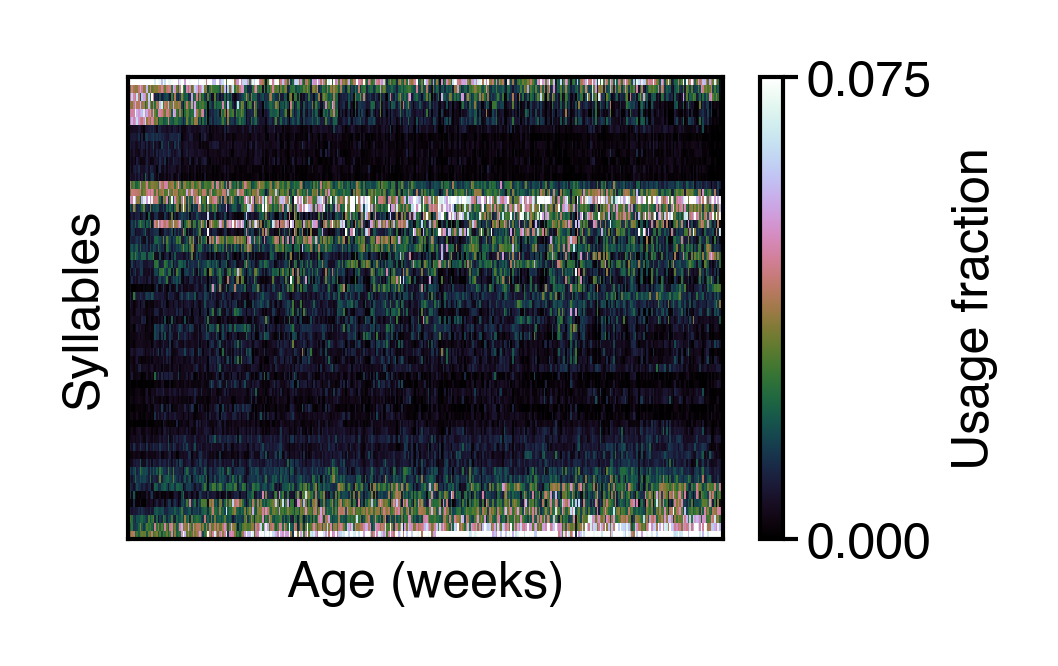

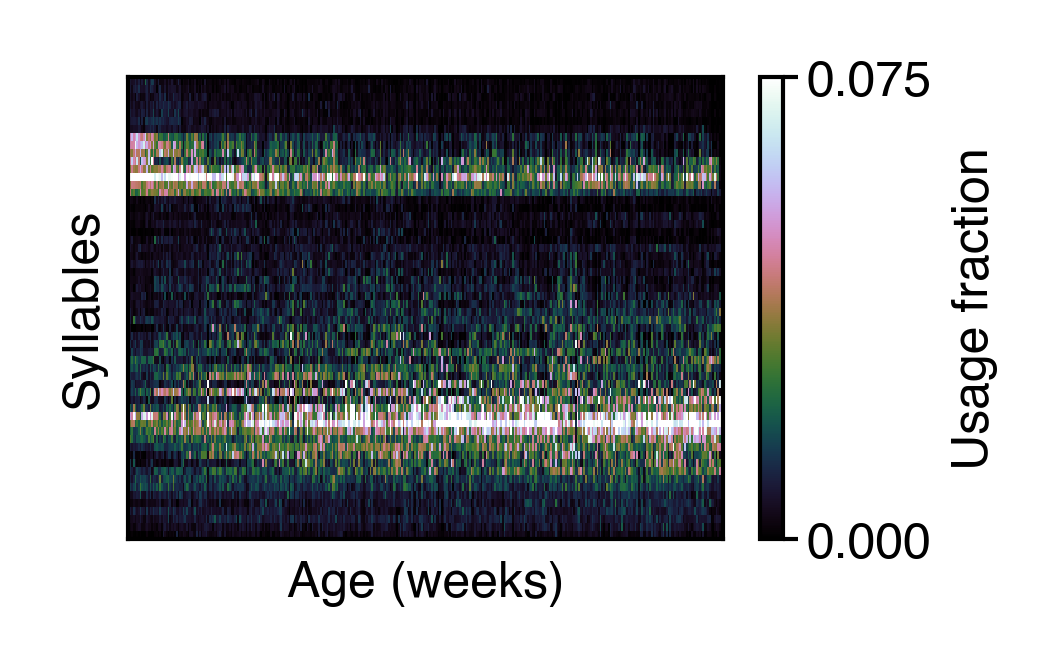

In [165]:
for i, _order in enumerate((plt_order, plt_order2)):
    with plt.rc_context(image_ctx):
        fig = figure(1.6, 1)
        ax = fig.gca()
        im = ax.imshow(df[_order].T, vmax=0.075, aspect='auto', vmin=0, extent=(ages.min(), ages.max(), len(df.T), 0))
        cb = fig.colorbar(mappable=im, ax=ax, label="Usage fraction")
        cb.set_ticks([0, 0.075])
        ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")
    # saver(fig, f"usage_plot_order-{i:02d}")

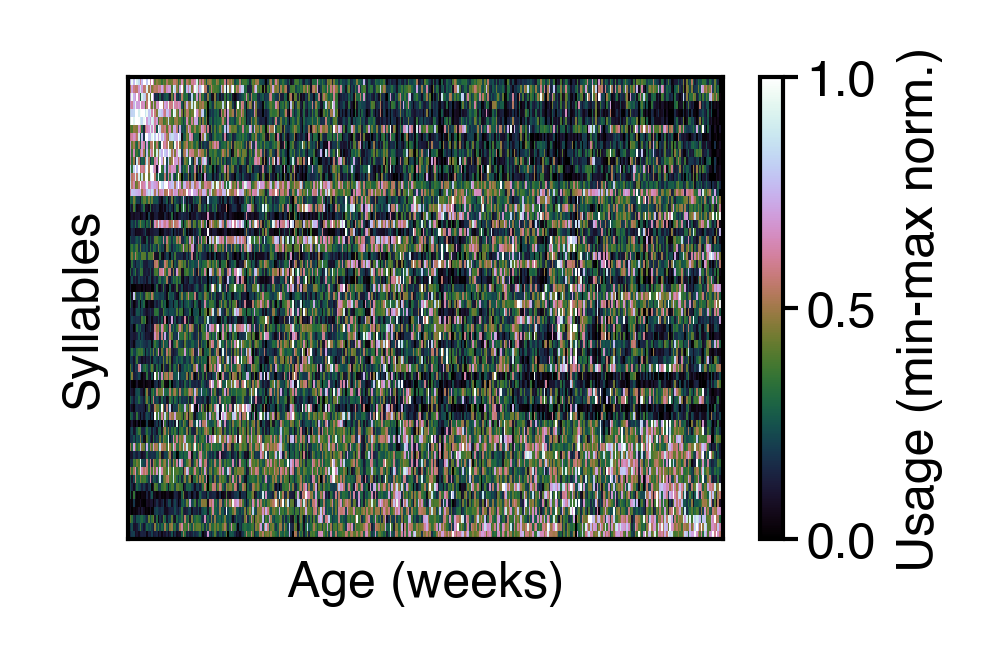

In [166]:
with plt.rc_context(image_ctx):
    fig = figure(1.6, 1)
    ax = fig.gca()
    im = ax.imshow(norm_df[plt_order].T, aspect='auto', vmin=0, vmax=1, extent=(ages.min(), ages.max(), len(df.T), 0))
    cb = fig.colorbar(mappable=im, ax=ax, label="Usage (min-max norm.)")
    cb.set_ticks([0, 0.5, 1])
    ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")
# saver(fig, "usage_plot_min_max");

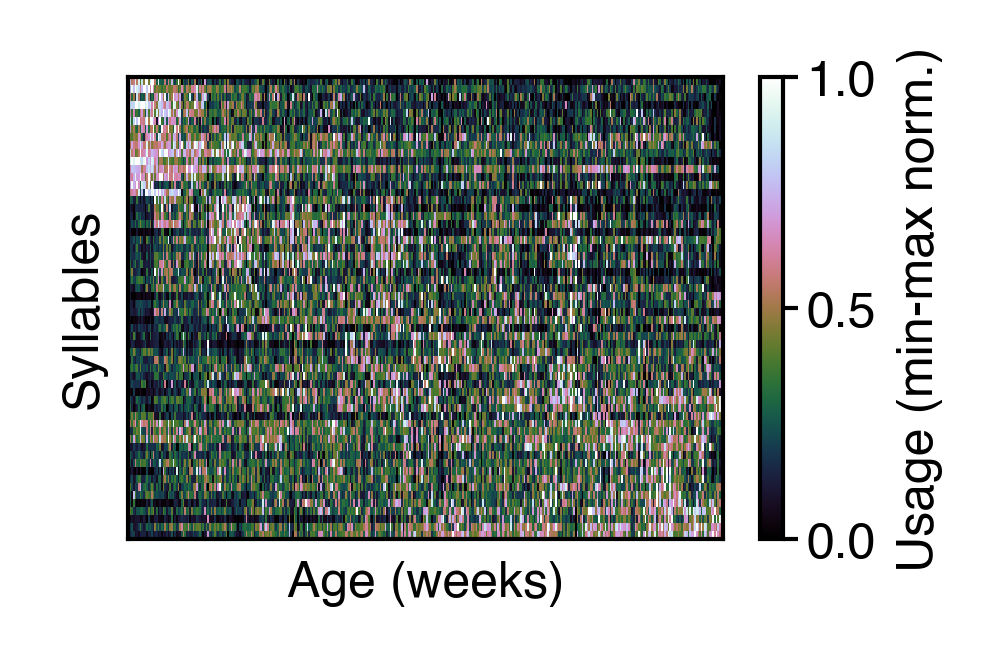

In [143]:
with plt.rc_context(image_ctx):
    fig = figure(1.6, 1)
    ax = fig.gca()
    im = ax.imshow(norm_df[norm_syll_sort].T, aspect='auto', vmin=0, vmax=1, extent=(ages.min(), ages.max(), len(df.T), 0))
    cb = fig.colorbar(mappable=im, ax=ax, label="Usage (min-max norm.)")
    cb.set_ticks([0, 0.5, 1])
    ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")
saver(fig, "usage_plot_min_max_norm_sort");

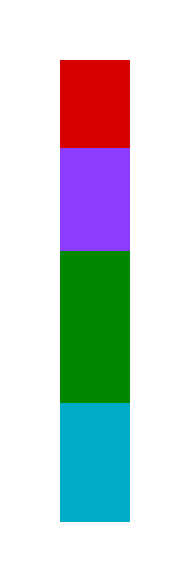

In [12]:
x = df_with_cluster.loc[pd.IndexSlice[:, plt_order], :].index.get_level_values('labels')

fig = figure(0.15, 1)
sns.heatmap(x.to_numpy()[:, None], cmap=cc.cm.glasbey, vmax=256, cbar=False)
plt.axis('off')
saver(fig, "cluster-labels-for-usage-plot")

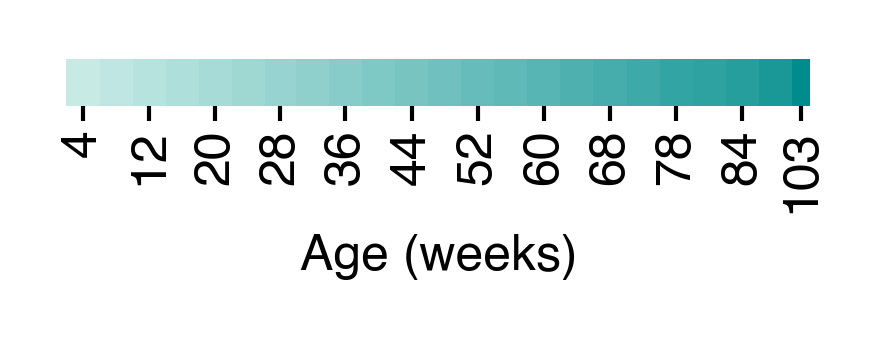

In [118]:
fig = figure(1.6, 0.1)

ax = sns.heatmap(ages.to_numpy()[None, :], cmap=onto_cmap, cbar=False)
offset = ages.value_counts(sort=False)
da_map = offset.cumsum()
ax.set(xticks=da_map.to_numpy()[::2] - offset.to_numpy()[::2] / 2, xticklabels=da_map.index[::2], xlabel="Age (weeks)")

saver(fig, "age-labels-for-usage-plot");

4 103


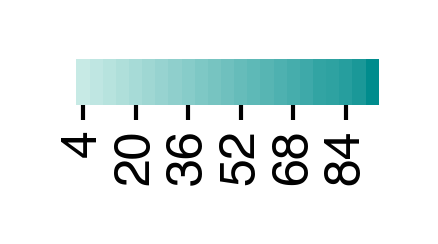

In [171]:
fig = figure(0.65, 0.1)

print(ages.min(), ages.max())
ax = sns.heatmap(ages.unique().to_numpy()[None, :], cmap=onto_cmap, cbar=False)
ax.set(xticklabels=ages.unique().to_numpy()[::4])
plt.xticks(rotation=90)
saver(fig, "age-labels-for-averaged-usage-plot");

In [17]:
# with plt.rc_context(image_ctx):
#     fig = figure(1.6, 1)
#     plt.imshow(np.log(df[plt_order].T), aspect='auto')
#     plt.colorbar()
# fig

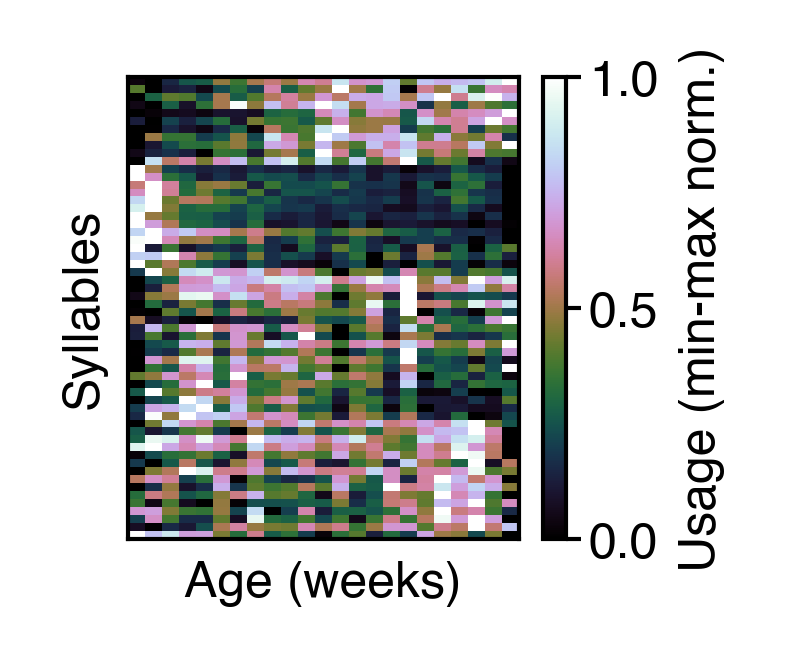

In [125]:
avg_df = df.groupby('age').mean()
avg_df = avg_df - avg_df.min()
avg_df = avg_df / avg_df.max()
with plt.rc_context(image_ctx):
    fig = figure(1.05, 1)
    ax = fig.gca()
    im = ax.imshow(avg_df[plt_order].T, aspect='auto', vmin=0, vmax=1, extent=(ages.min(), ages.max(), len(df.T), 0))
    cb = fig.colorbar(mappable=im, ax=ax, label="Usage (min-max norm.)")
    cb.set_ticks([0, 0.5, 1])
    ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")

saver(fig, "averaged_usage_plot_minmax_norm");

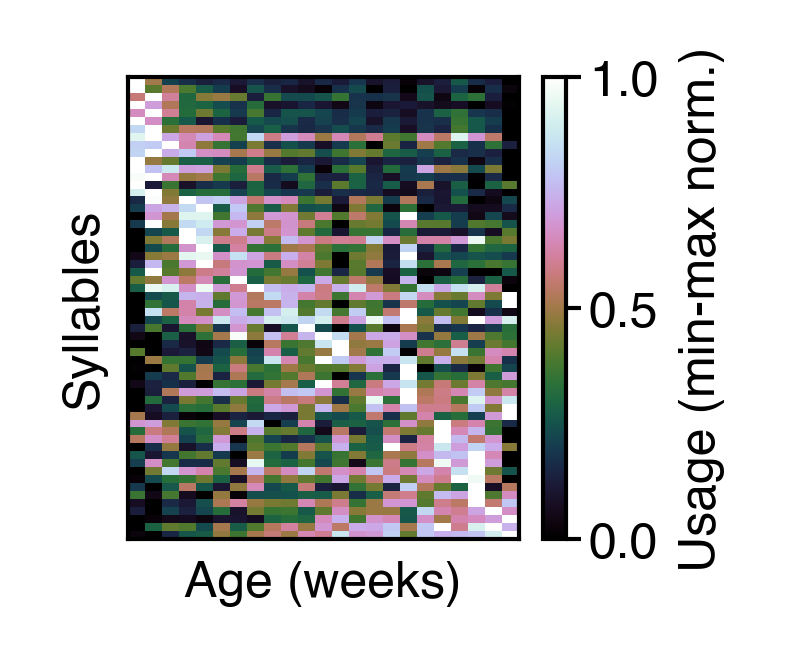

In [144]:
avg_df = df.groupby('age').mean()
avg_df = avg_df - avg_df.min()
avg_df = avg_df / avg_df.max()
with plt.rc_context(image_ctx):
    fig = figure(1.05, 1)
    ax = fig.gca()
    im = ax.imshow(avg_df[norm_syll_sort].T, aspect='auto', vmin=0, vmax=1, extent=(ages.min(), ages.max(), len(df.T), 0))
    cb = fig.colorbar(mappable=im, ax=ax, label="Usage (min-max norm.)")
    cb.set_ticks([0, 0.5, 1])
    ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")

saver(fig, "averaged_usage_plot_minmax_norm_norm_sort");

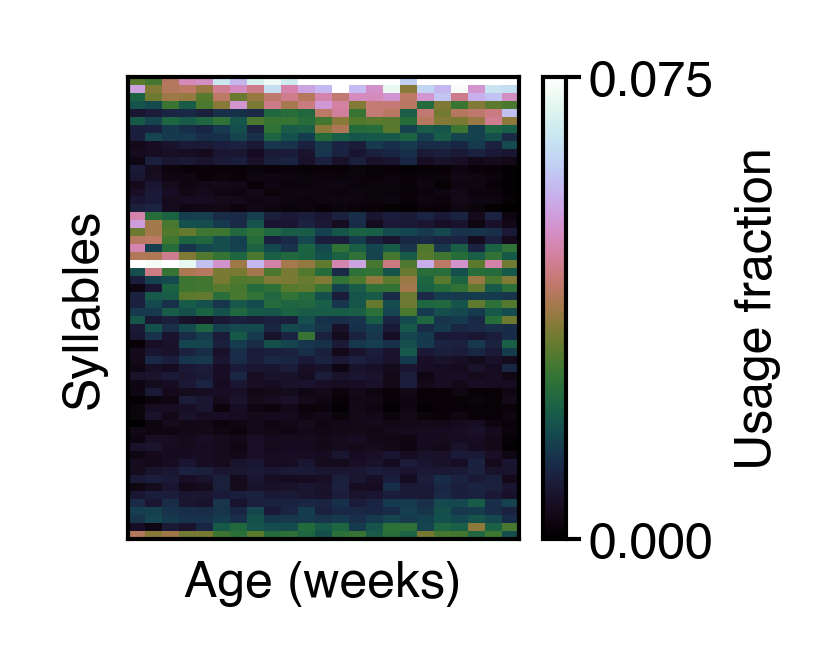

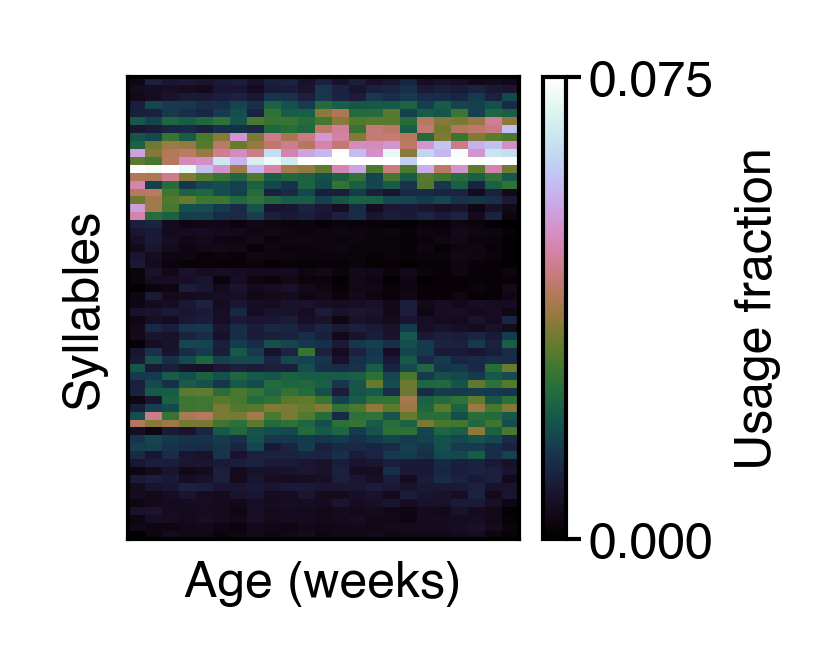

In [18]:
for i, _order in enumerate((plt_order, plt_order2)):
    with plt.rc_context(image_ctx):
        fig = figure(1.05, 1)
        ax = fig.gca()
        im = ax.imshow(df.groupby('age').mean()[_order].T, vmax=0.075, aspect='auto', vmin=0, extent=(ages.min(), ages.max(), len(df.T), 0))
        cb = fig.colorbar(mappable=im, ax=ax, label="Usage fraction")
        cb.set_ticks([0, 0.075])
        ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")
    saver(fig, f"averaged_usage_plot_order-{i:02d}")
    plt.show()

In [19]:
# with plt.rc_context(image_ctx):
#     fig = figure(1.1, 1)
#     plt.imshow(np.log(df.groupby('age').mean())[plt_order].T,  aspect='auto')
#     plt.colorbar()
# fig

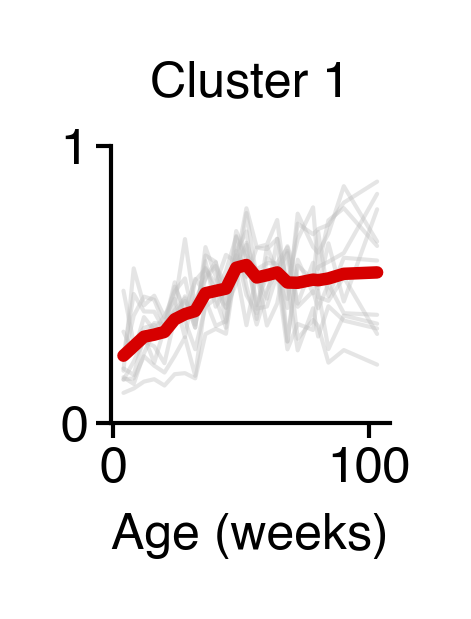

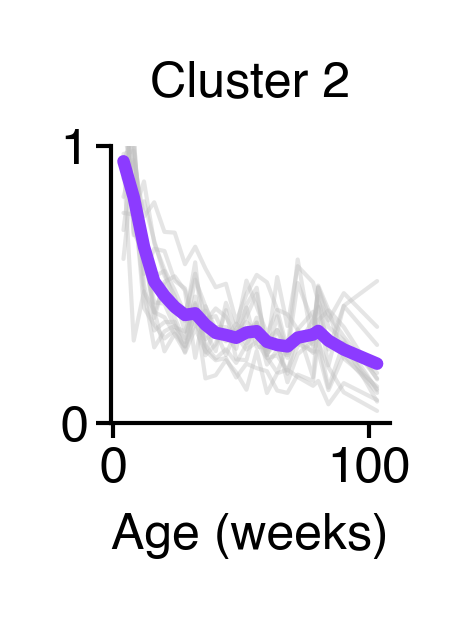

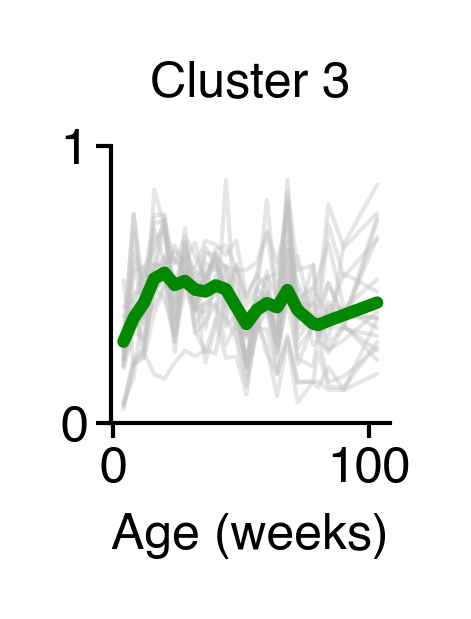

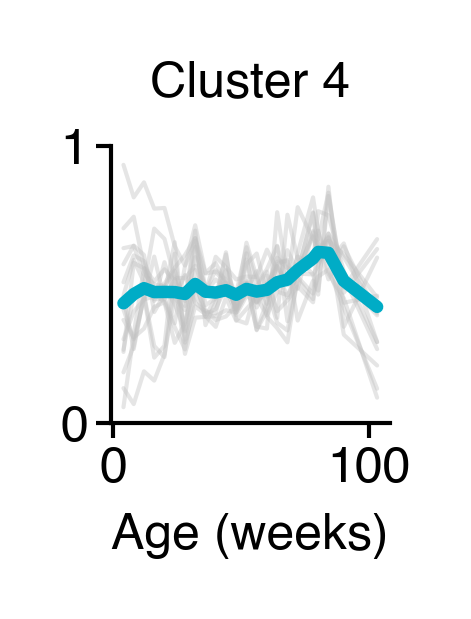

In [20]:
for _lbl, _df in norm_df.T.groupby(list(map(new_map_order.get, lbls))):
    fig = figure(0.6, 0.6)
    ax = fig.gca()
    ax = (
        _df.T.groupby("age")
        .mean()
        .plot(ax=ax, legend=False, color="silver", lw=0.5, alpha=0.4)
    )
    ax.plot(
        _df.T.groupby("age")
        .mean()
        .mean(1)
        .rolling(5, win_type="gaussian", min_periods=1, center=True)
        .mean(std=0.75),
        lw=1.5,
        color=cc.glasbey[_lbl],
    )
    ax.set(ylim=(0, 1), yticks=[0, 1], xlabel="Age (weeks)", title=f"Cluster {_lbl + 1}")
    sns.despine()
    saver(fig, f"clustered-usage-cluster-{_lbl}")
plt.show()

In [21]:
plt.close('all')

## Averaged distance matrices

In [22]:
avg_df = df.groupby('age').mean()

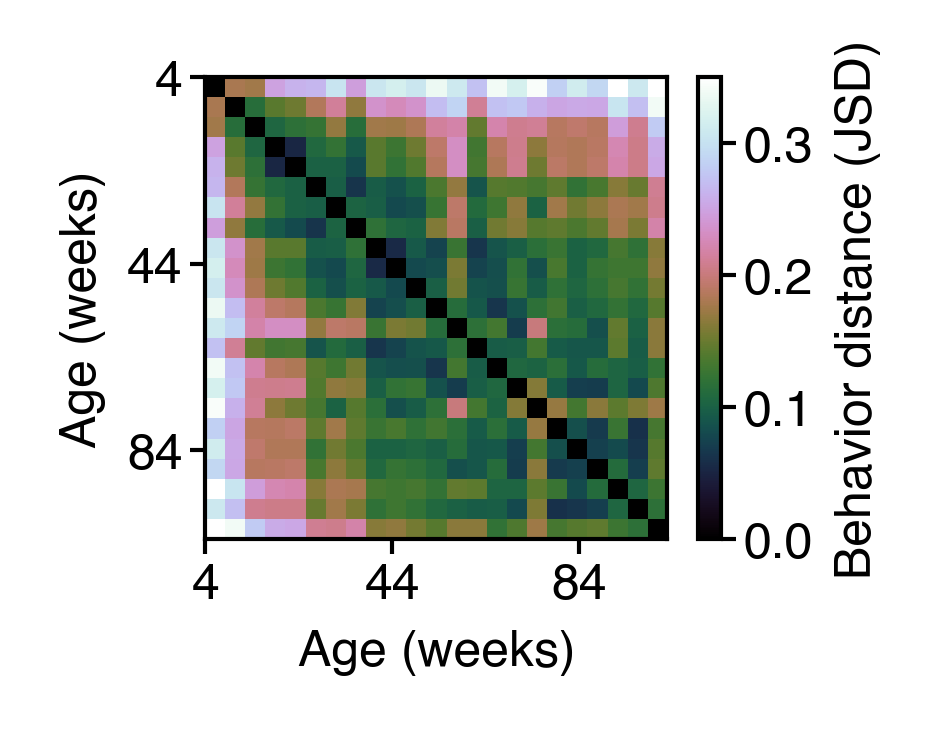

In [23]:
dists = squareform(pdist(avg_df, metric='jensenshannon'))
with plt.rc_context(image_ctx):
    fig = figure(1.3, 1)
    ax = fig.gca()
    im = ax.imshow(dists, vmax=0.35, extent=(ages.min(), ages.max(), ages.max(), ages.min()))
    fig.colorbar(mappable=im, ax=ax, label="Behavior distance (JSD)")
    ax.set(xticks=[4, 44, 84], yticks=[4, 44, 84], xlabel="Age (weeks)", ylabel="Age (weeks)")
saver(fig, "averaged-behavior-distance-matrix")

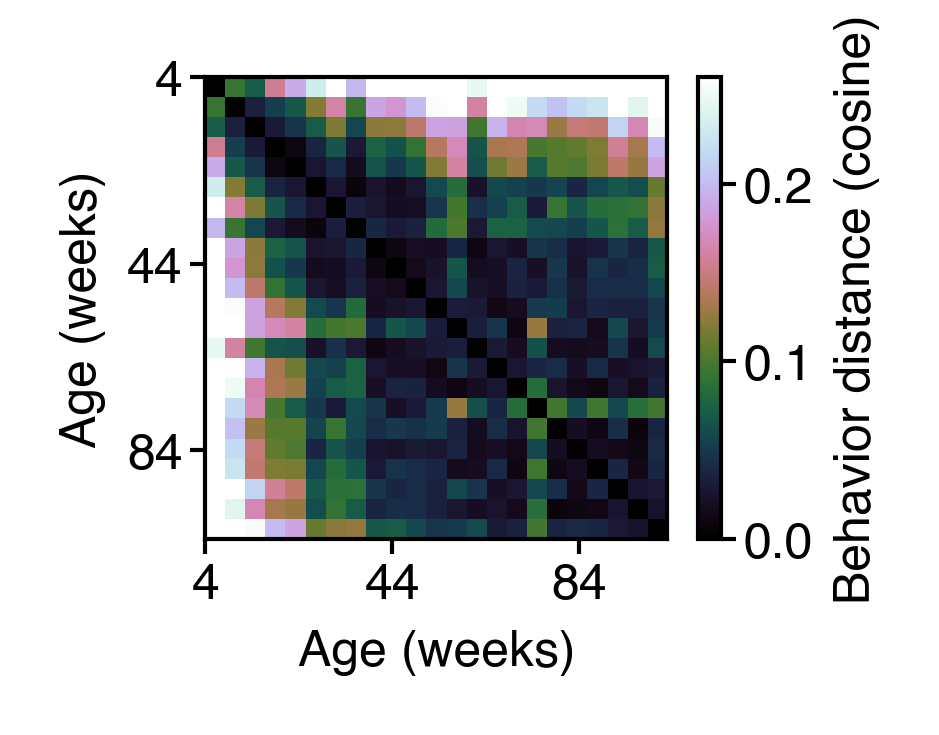

In [24]:
dists = squareform(pdist(avg_df, metric='cosine'))
with plt.rc_context(image_ctx):
    fig = figure(1.3, 1)
    ax = fig.gca()
    im = ax.imshow(dists, vmax=0.26, extent=(ages.min(), ages.max(), ages.max(), ages.min()))
    fig.colorbar(mappable=im, ax=ax, label="Behavior distance (cosine)")
    ax.set(xticks=[4, 44, 84], yticks=[4, 44, 84], xlabel="Age (weeks)", ylabel="Age (weeks)")
saver(fig, "averaged-behavior-distance-matrix-cosine")

## Full distance matrices

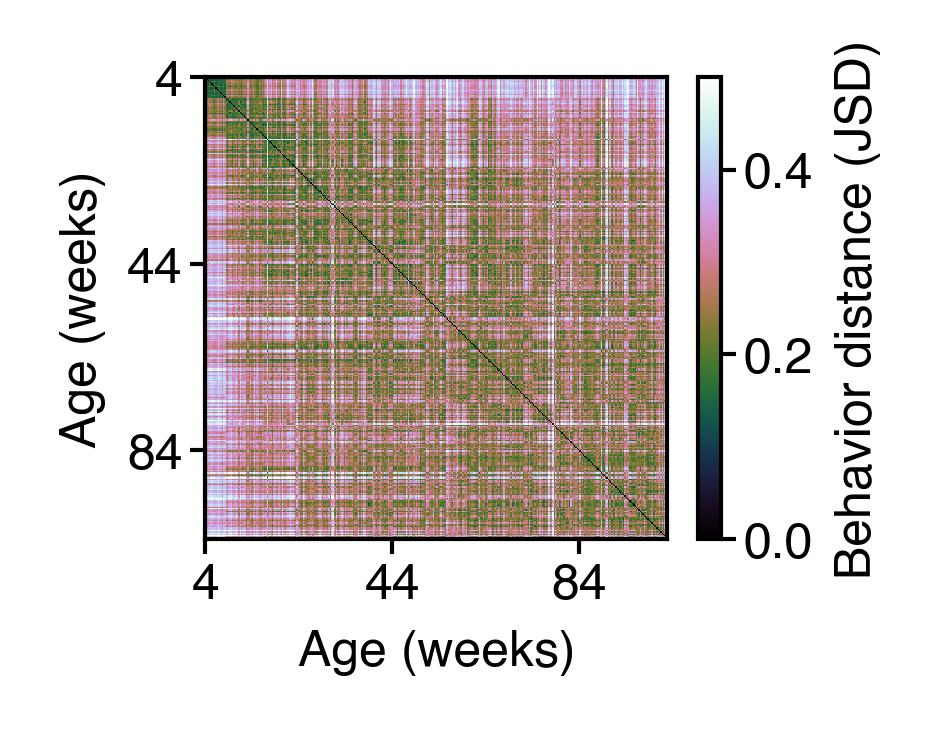

In [25]:
dists = squareform(pdist(df, metric='jensenshannon'))
with plt.rc_context(image_ctx):
    fig = figure(1.3, 1)
    ax = fig.gca()
    im = ax.imshow(dists, vmax=0.5, extent=(ages.min(), ages.max(), ages.max(), ages.min()))
    fig.colorbar(mappable=im, ax=ax, label="Behavior distance (JSD)")
    ax.set(xticks=[4, 44, 84], yticks=[4, 44, 84], xlabel="Age (weeks)", ylabel="Age (weeks)")
saver(fig, "full-behavior-distance-matrix")

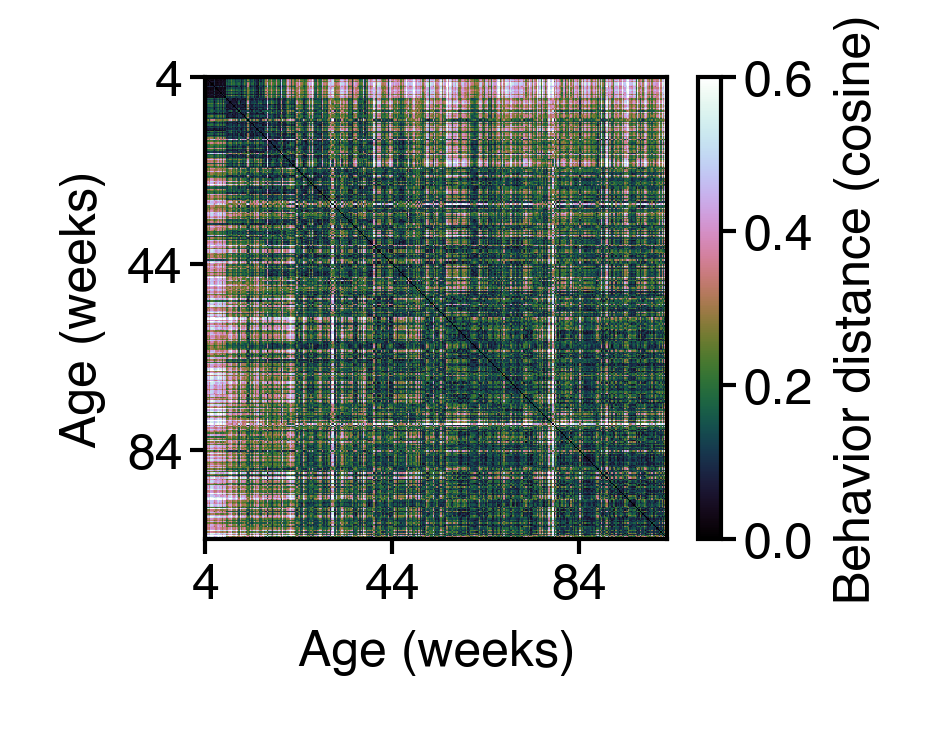

In [26]:
dists = squareform(pdist(df, metric='cosine'))
with plt.rc_context(image_ctx):
    fig = figure(1.3, 1)
    ax = fig.gca()
    im = ax.imshow(dists, vmax=0.6, extent=(ages.min(), ages.max(), ages.max(), ages.min()))
    fig.colorbar(mappable=im, ax=ax, label="Behavior distance (cosine)")
    ax.set(xticks=[4, 44, 84], yticks=[4, 44, 84], xlabel="Age (weeks)", ylabel="Age (weeks)")
saver(fig, "full-behavior-distance-matrix-cosine")

## K-means silhouette score

In [27]:
ss_d = {}
for i in range(2, 7):
    km = KMeans(n_clusters=i, random_state=0)
    lbls = km.fit_predict(norm_df.T)
    ss = silhouette_score(norm_df.T, lbls)
    ss_d[i] = ss
ss_d

{2: 0.09926693698379782,
 3: 0.1222068033039928,
 4: 0.13271514344056393,
 5: 0.1284742734949697,
 6: 0.10846024736306195}

In [28]:
plt.close('all')

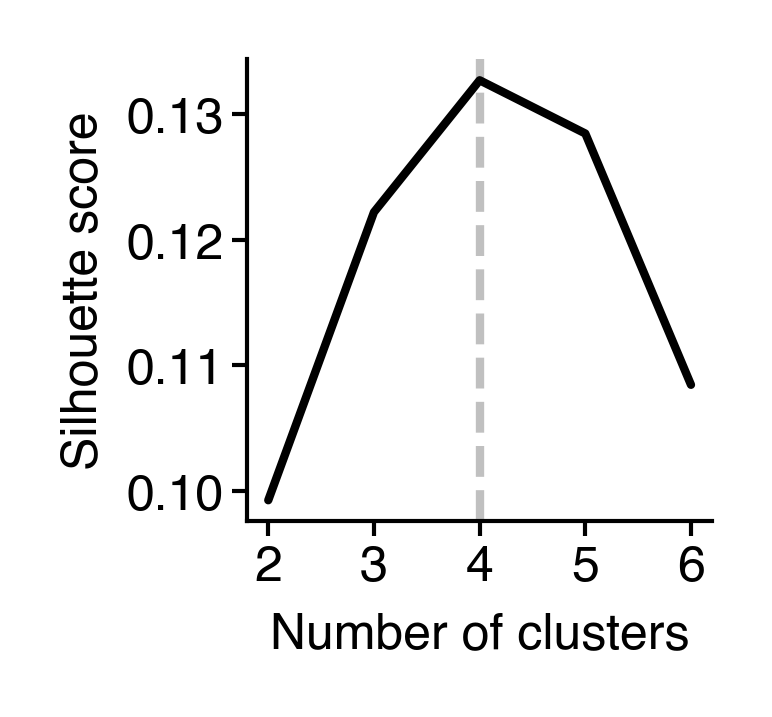

In [29]:
fig = figure(1, 1)
ax = fig.gca()
ax = pd.Series(ss_d).plot(ax=ax, color='k')
ax.set(ylabel='Silhouette score', xlabel='Number of clusters', xticks=range(2, 7))
ax.axvline(4, color='silver', zorder=-1, ls='--')
sns.despine()
saver(fig, 'silhouette-score-kmeans')

## PCA of syllable usage

In [126]:
pcs = PCA(n_components=2).fit_transform(df)

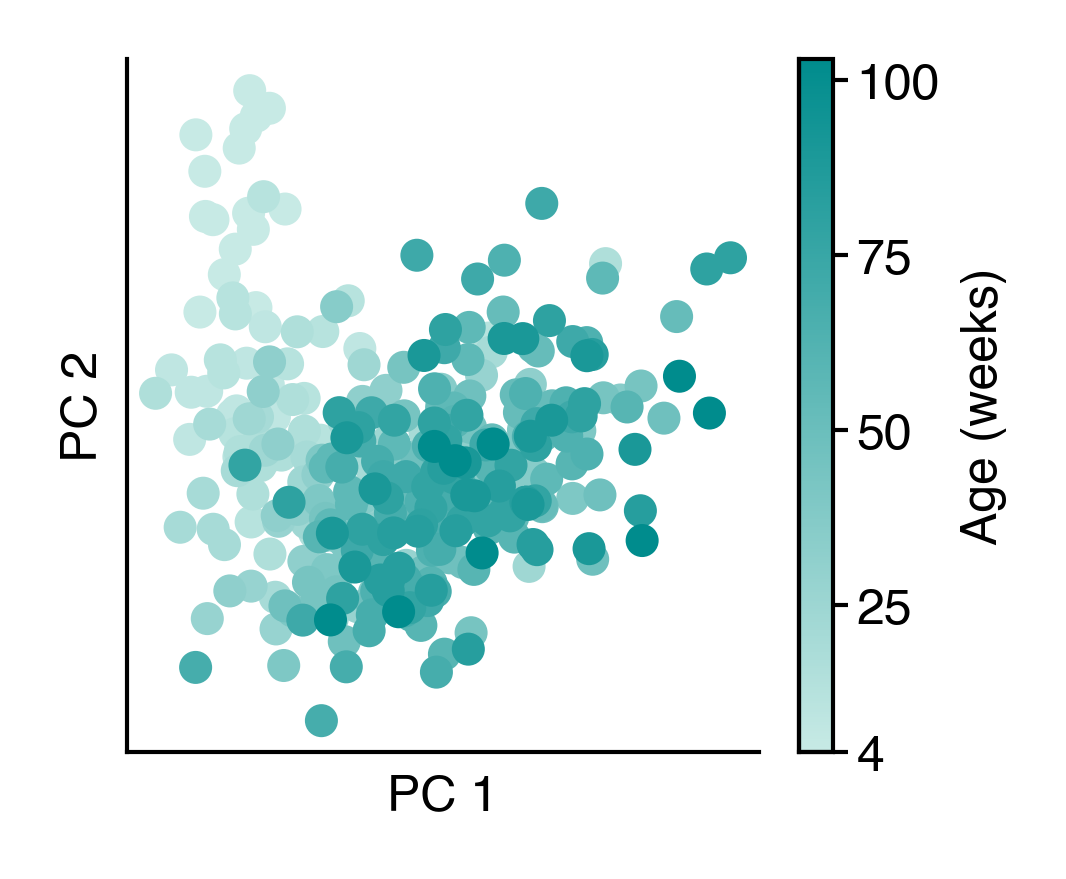

In [128]:
fig = figure(1.7, 1.5)
ax = fig.gca()
im = ax.scatter(pcs[:, 0], pcs[:, 1], c=ages, cmap=onto_cmap, s=10)
cb = fig.colorbar(im, ax=ax, label="Age (weeks)")
cb.set_ticks([4, 25, 50, 75, 100])
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, "pca-scores");

In [129]:
pcs = PCA(n_components=2).fit_transform(norm_df)

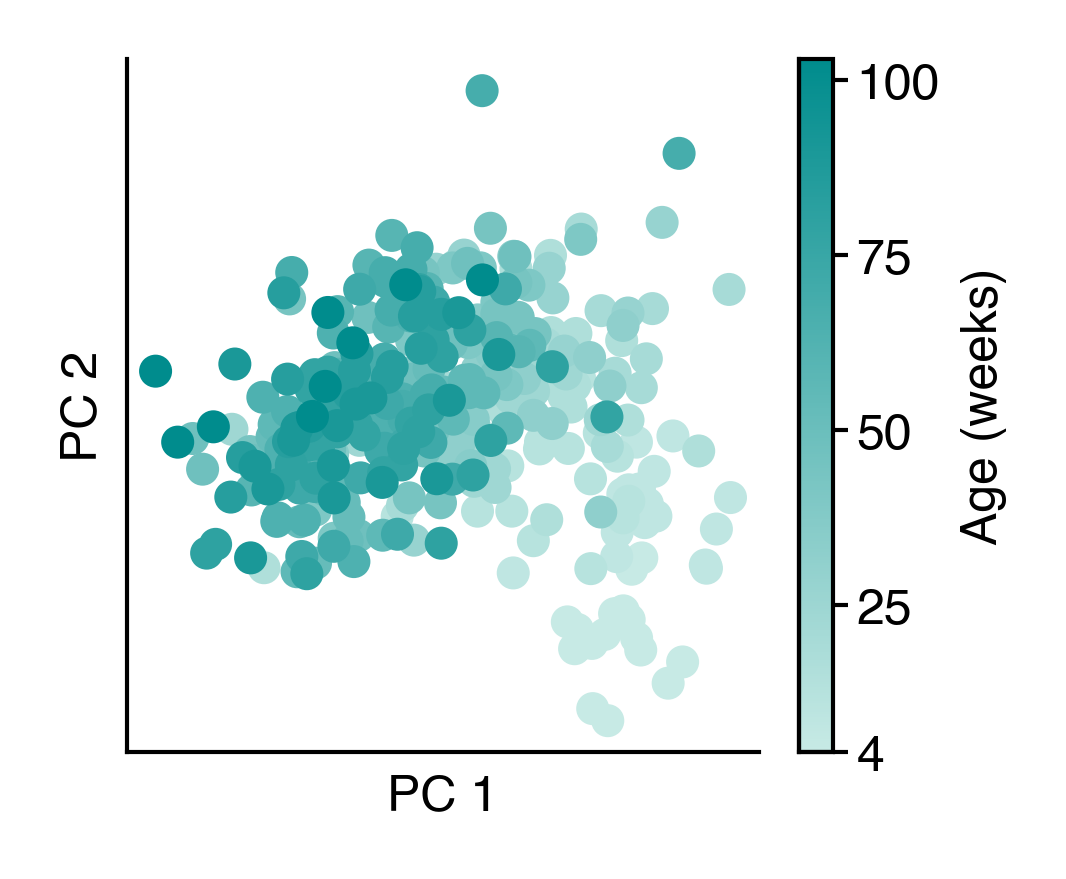

In [131]:
fig = figure(1.7, 1.5)
ax = fig.gca()
im = ax.scatter(pcs[:, 0], pcs[:, 1], c=ages, cmap=onto_cmap, s=10)
cb = fig.colorbar(im, ax=ax, label="Age (weeks)")
cb.set_ticks([4, 25, 50, 75, 100])
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, "pca-scores-minmax-norm");

## Inter-individual distances

In [11]:
import matplotlib.colors as mpc

In [12]:
plt.close('all')

In [24]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in df.groupby('age'):
    inter_ind_dists = pdist(_df, metric='jensenshannon')
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age)))
iid_df = pd.concat(iid_df)
iid_avg_df = pd.concat(iid_avg_df)

In [25]:
normalizer = mpc.Normalize(vmin=min(iid), vmax=max(iid))
onto_color_list = onto_cmap(normalizer(list(iid)))

/tmp/ipykernel_6274/2997983759.py:2: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  a = sns.boxplot(data=iid, showfliers=False, showcaps=False, palette=onto_color_list)


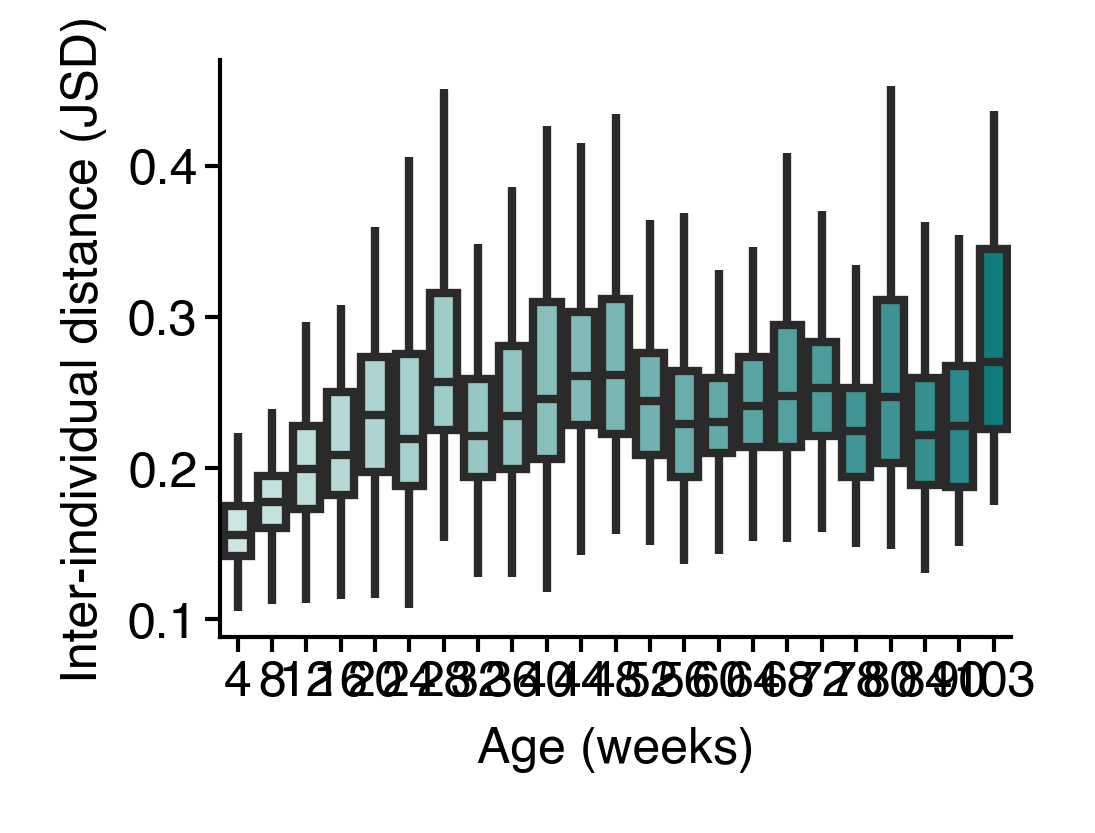

In [26]:
fig = figure(1.7, 1.25)
a = sns.boxplot(data=iid, showfliers=False, showcaps=False, palette=onto_color_list)
a.set(xlabel="Age (weeks)", ylabel="Inter-individual distance (JSD)")
sns.despine()
# saver(fig, "iid-jsd-boxplot")

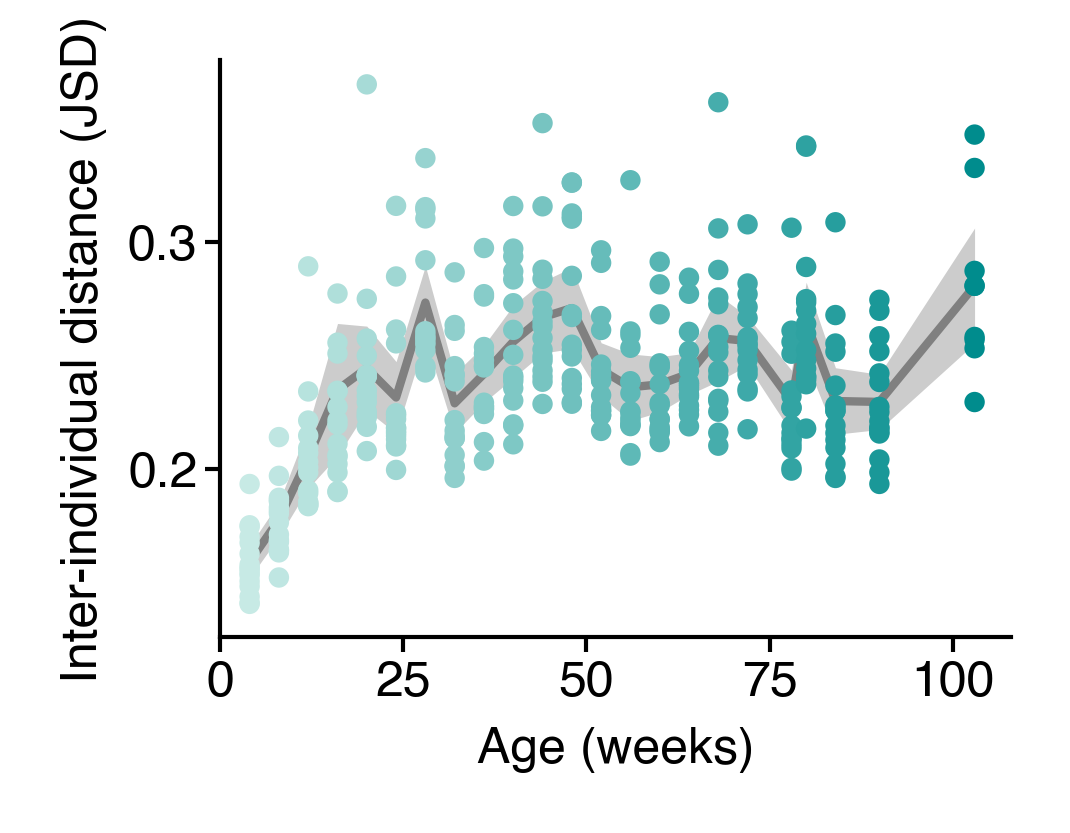

In [27]:
fig = figure(1.7, 1.25)
a = sns.lineplot(data=iid_avg_df, x='age', y='iid', zorder=-1, color='gray', err_kws={'lw': 0, 'alpha': 0.4}, errorbar=("se", 2))
a = sns.scatterplot(data=iid_avg_df, x='age', y='iid', palette=onto_cmap, hue='age', legend=False, s=6, linewidths=0, alpha=1, zorder=1)
a.set(ylim=(None, 0.38), xlim=(0, None), xlabel="Age (weeks)", ylabel="Inter-individual distance (JSD)")
sns.despine()
# saver(fig, "iid-jsd-scatter")

In [38]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in df.groupby('age'):
    inter_ind_dists = pdist(_df, metric='cosine')
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age)))
iid_df = pd.concat(iid_df)
iid_avg_df = pd.concat(iid_avg_df)

/tmp/ipykernel_858/2361874992.py:2: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  a = sns.boxplot(data=iid, showfliers=False, showcaps=False, palette=onto_color_list)


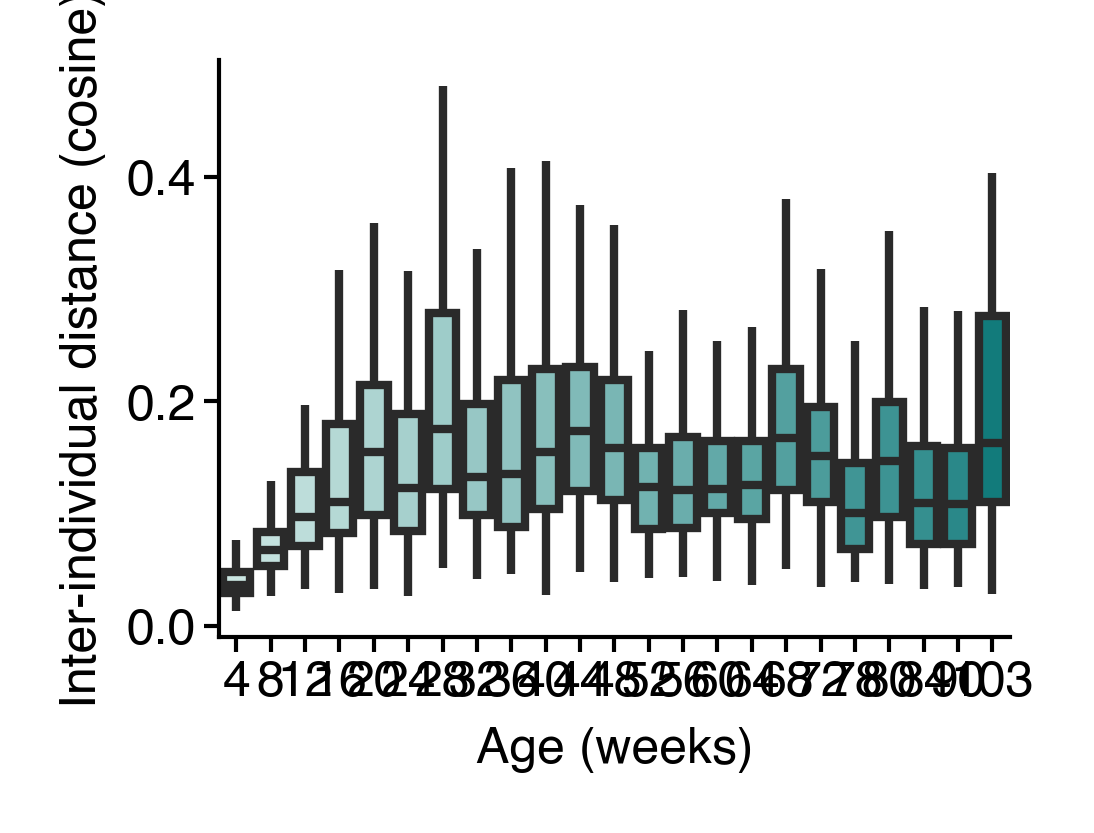

In [39]:
fig = figure(1.7, 1.25)
a = sns.boxplot(data=iid, showfliers=False, showcaps=False, palette=onto_color_list)
a.set(xlabel="Age (weeks)", ylabel="Inter-individual distance (cosine)")
sns.despine()
saver(fig, "iid-cosine-boxplot")

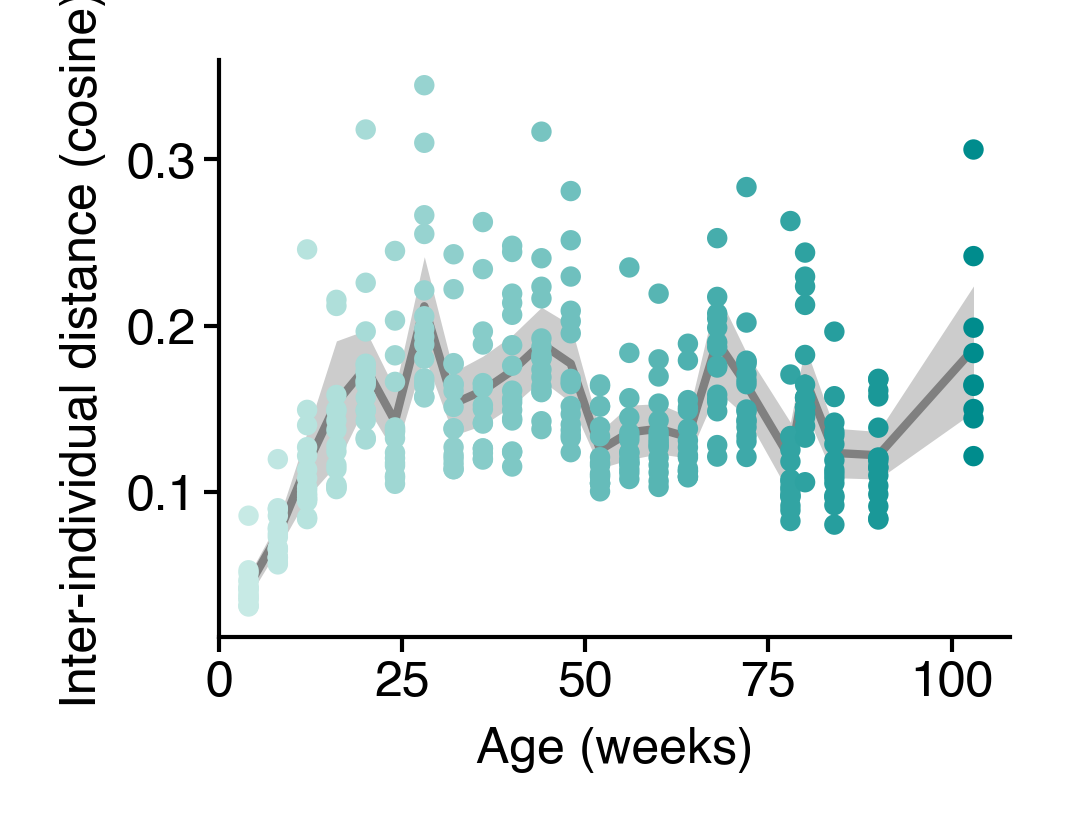

In [40]:
fig = figure(1.7, 1.25)
a = sns.lineplot(data=iid_avg_df, x='age', y='iid', zorder=-1, color='gray', err_kws={'lw': 0, 'alpha': 0.4}, errorbar=("se", 2))
a = sns.scatterplot(data=iid_avg_df, x='age', y='iid', palette=onto_cmap, hue='age', legend=False, s=6, linewidths=0, alpha=1, zorder=1)
a.set(ylim=(None, 0.36), xlim=(0, None), xlabel="Age (weeks)", ylabel="Inter-individual distance (cosine)")
sns.despine()
saver(fig, "iid-cosine-scatter")

In [41]:
plt.close('all')

## Rate of change

In [42]:
n_boot = 1_000
boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize
    norm_diff -= np.nanmin(norm_diff)
    norm_diff /= np.nanmax(norm_diff)

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )

boot_df = pd.DataFrame(boots).T.reset_index()
boot_df = boot_df.melt(id_vars="age")

In [43]:
# boot_df['value'] = boot_df['value'] - boot_df['value'].min()
# boot_df['value'] = boot_df['value'] / boot_df['value'].max()

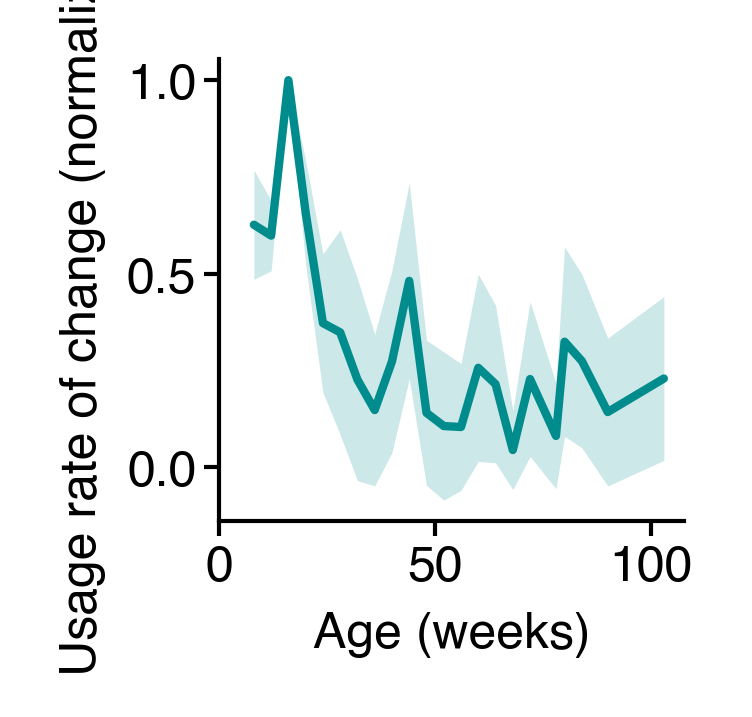

In [44]:
fig = figure(1, 1)
ax = sns.lineplot(
    data=boot_df,
    x="age",
    y="value",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color=colors[-1],
)
ax.set(xlim=(0, 105), ylabel="Usage rate of change (normalized)", xlabel="Age (weeks)")
sns.despine()
saver(fig, "ontogeny-male-rate-of-change")

In [24]:
n_boot = 1_000
boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )

boot_df = pd.DataFrame(boots).T.reset_index()
boot_df = boot_df.melt(id_vars="age")

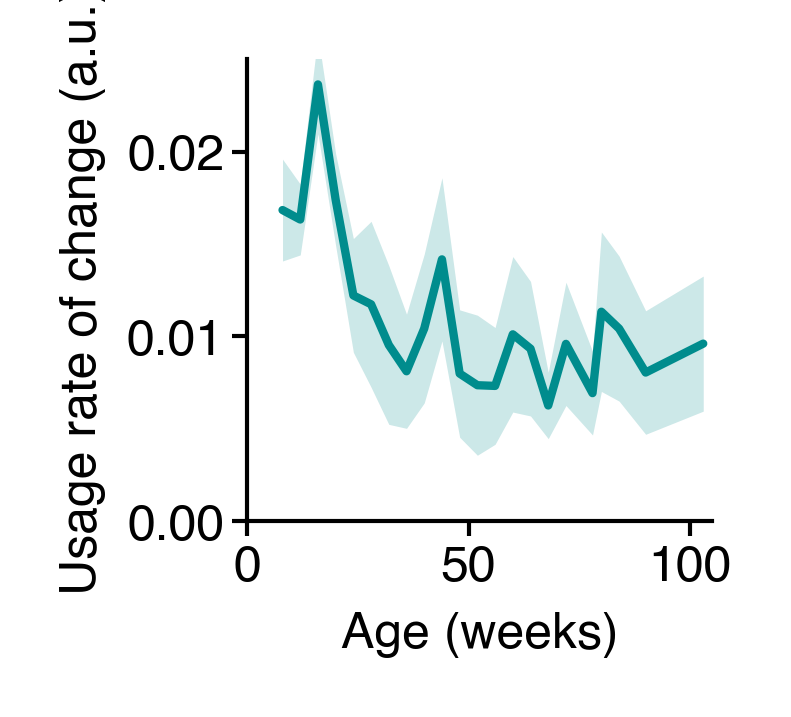

In [30]:
fig = figure(1, 1)
ax = sns.lineplot(
    data=boot_df,
    x="age",
    y="value",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color=colors[-1],
)
ax.set(xlim=(0, 105), ylabel="Usage rate of change (a.u.)", xlabel="Age (weeks)", ylim=(0, 0.025))
sns.despine()
saver(fig, "ontogeny-male-rate-of-change-unnormalized");

## NMF

In [8]:
from sklearn.decomposition import NMF

In [83]:
norm_df = df - df.min()
norm_df = norm_df / norm_df.quantile(0.95)

In [218]:
n_boot = 1_00
boots = []
for i in tqdm(range(n_boot)):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    avg_usage = avg_usage - avg_usage.min()
    avg_usage = avg_usage / avg_usage.quantile(0.99)

    nmf = NMF(n_components=4, random_state=0, max_iter=4000)
    scores = nmf.fit_transform(avg_usage)
    boots.append(
        pd.DataFrame(scores, index=avg_usage.index)
    )
boot_df = pd.concat(boots).reset_index()
boot_df = boot_df.melt(id_vars="age", var_name='component')

  0%|          | 0/100 [00:00<?, ?it/s]

In [216]:
n_boot = 100

e = {}
for i in tqdm(range(1, 8)):
    e[i] = []
    for b in range(n_boot):
        sampled = df.groupby('age').sample(frac=1, replace=True, random_state=b)
        avg_usage = sampled.groupby("age").mean()
        avg_usage = avg_usage - avg_usage.min()
        avg_usage = avg_usage / avg_usage.quantile(0.99)
        nmf = NMF(n_components=i, random_state=0, max_iter=6000)
        nmf.fit(avg_usage)
        e[i].append(nmf.reconstruction_err_)
e = pd.DataFrame(e)

  0%|          | 0/7 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 6000 reached. Increase it to improve convergence.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 6000 reached. Increase it to improve convergence.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 6000 reached. Increase it to improve convergence.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 6000 reached. Increase it to improve convergence.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iteratio

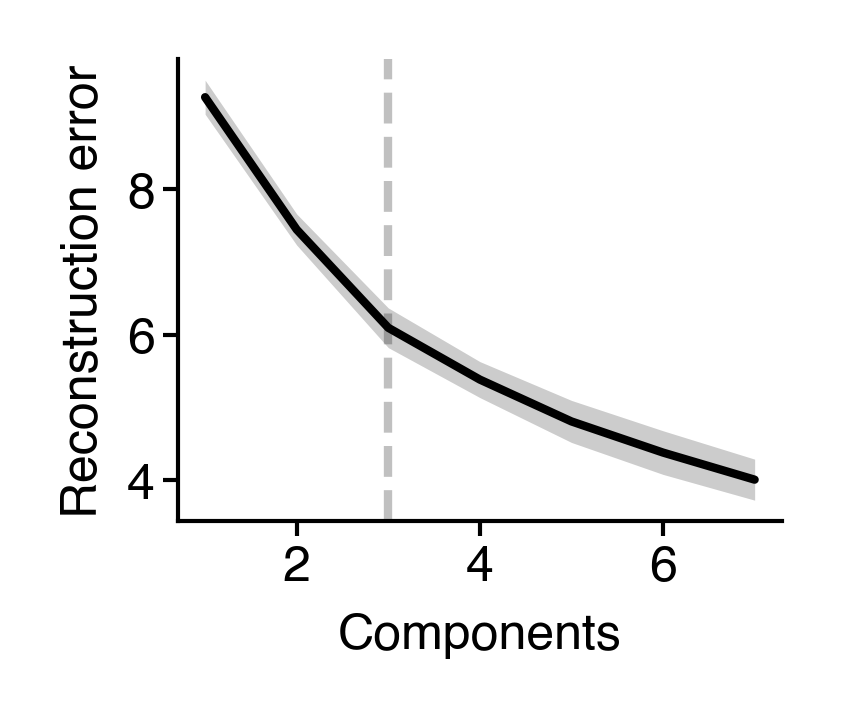

In [217]:
fig = figure(1.3, 1)
ax = sns.lineplot(data=e.melt(), x='variable', y='value', errorbar=('sd', 2), color='k', err_kws=dict(lw=0))
ax.set(xlabel="Components", ylabel="Reconstruction error")
ax.axvline(3, ls='--', c='silver', zorder=-1)
sns.despine()
saver(fig, "nmf-reconstruction-error");

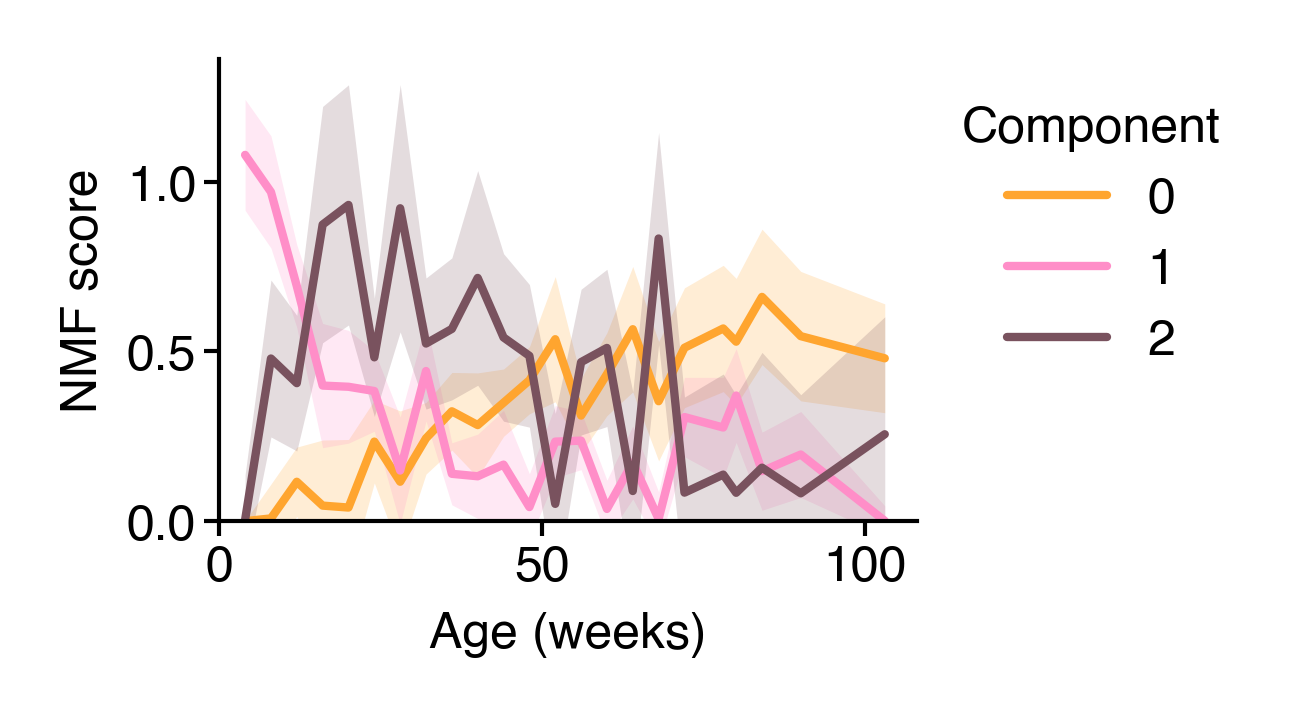

In [214]:
fig = figure(1.5, 1)
ax = sns.lineplot(data=boot_df, x='age', y='value', hue='component', palette=cc.glasbey_light[5:8], errorbar=('sd', 2), err_kws=dict(lw=0))
legend(ax, title="Component")
ax.set(xlabel="Age (weeks)", ylabel="NMF score", xlim=(0, None), ylim=(0, None))
sns.despine()
saver(fig, 'nmf-components-with-error');

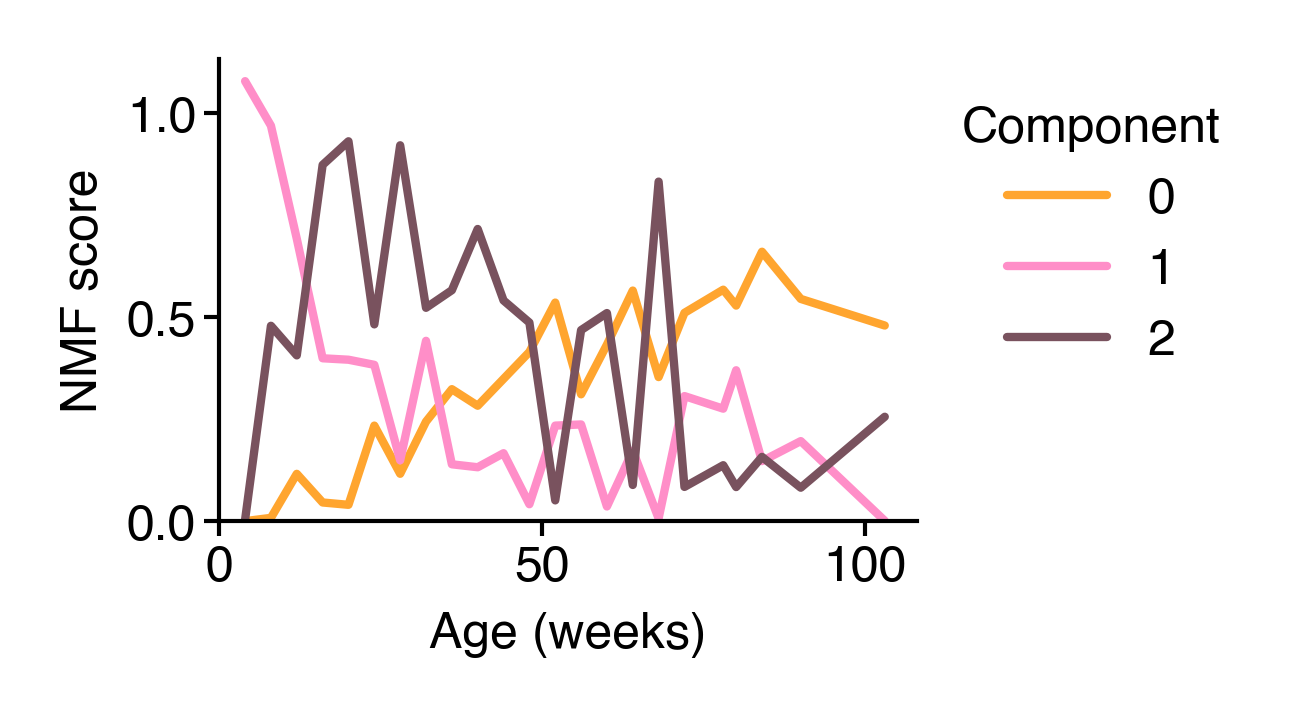

In [215]:
fig = figure(1.5, 1)
ax = sns.lineplot(data=boot_df, x='age', y='value', hue='component', palette=cc.glasbey_light[5:8], errorbar=None, err_kws=dict(lw=0))
legend(ax, title="Component")
ax.set(xlabel="Age (weeks)", ylabel="NMF score", xlim=(0, None), ylim=(0, None))
sns.despine()
saver(fig, 'nmf-components-no-error');

In [172]:
avg_usage = norm_df.groupby("age").mean()
nmf = NMF(n_components=3, random_state=0, max_iter=4000)
scores = nmf.fit_transform(avg_usage)

In [175]:
comps = nmf.components_

In [210]:
idx = np.argsort(np.dot(comps.T, np.array([1, 0.1, -0.8])))[::-1]

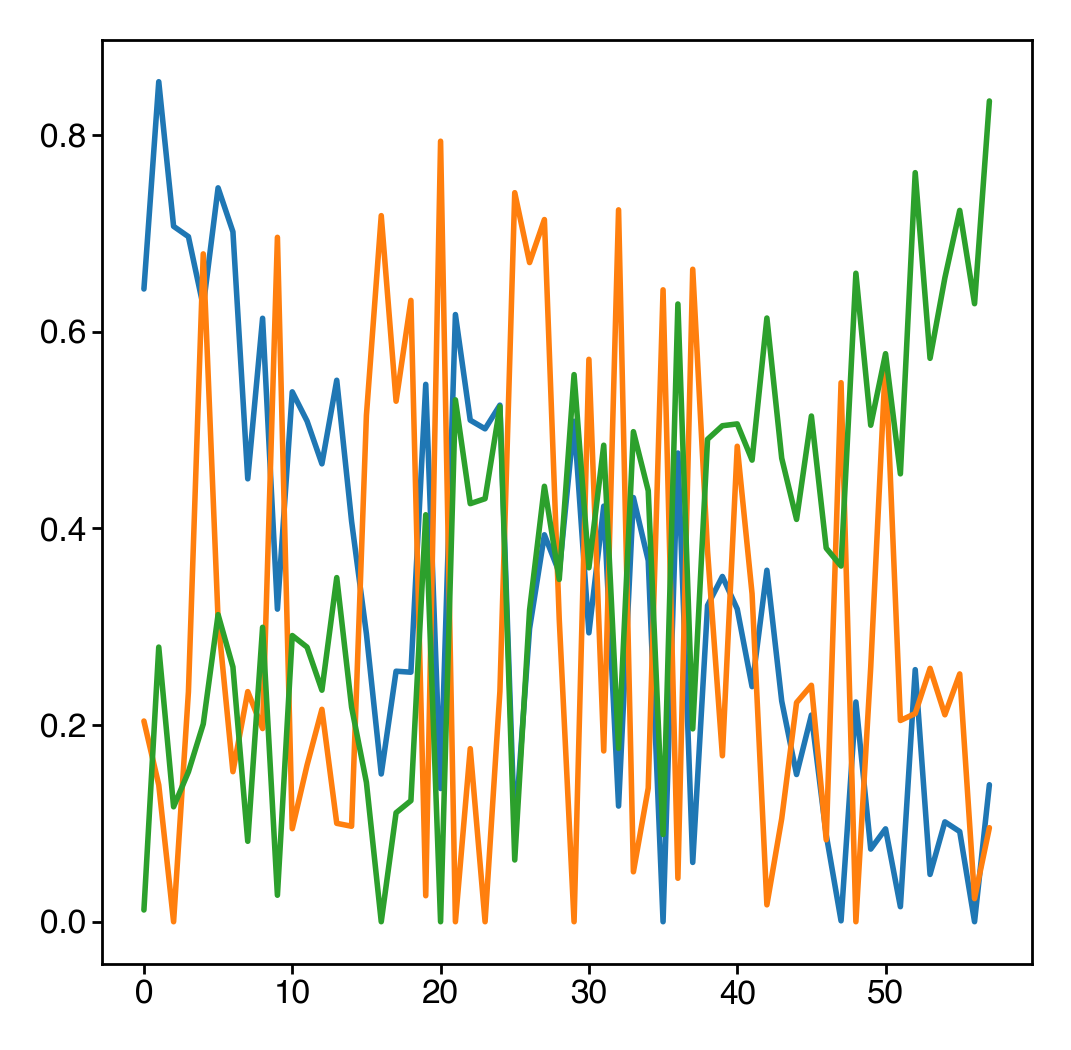

In [211]:
plt.plot(nmf.components_[:, idx].T)

## Entropy of syllable usage

In [ ]:
from scipy.stats import entropy

In [ ]:
ent = pd.Series(entropy(df.to_numpy() + 1e-4, axis=1), index=df.index)
ent.name = 'entropy'

In [ ]:
fig = figure(1.7, 1.25)
ax = sns.boxplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    showfliers=False,
    showcaps=False,
    hue="age",
    palette=list(onto_color_list),
    legend=False,
)
ax.set(xlabel='Age (weeks)', ylabel='Behavioral variability (nats)')
sns.despine()
saver(fig, "usage-entropy-boxplot")

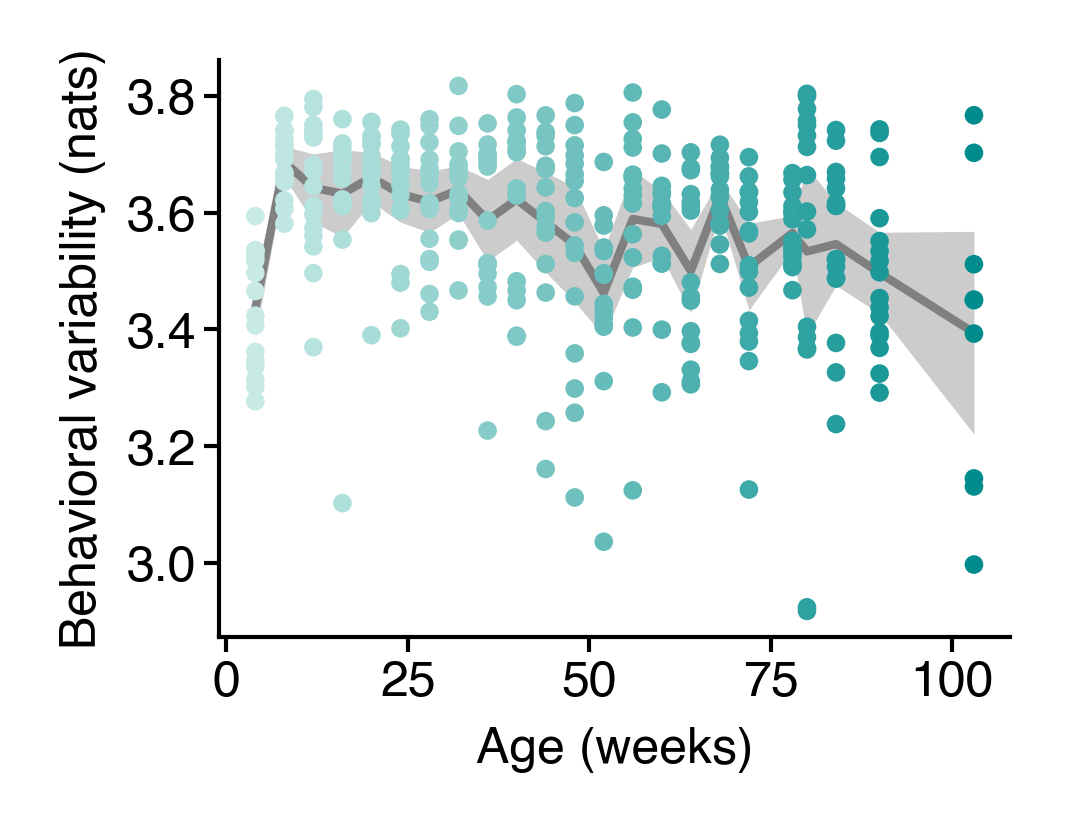

In [54]:
fig = figure(1.7, 1.25)
ax = sns.lineplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    zorder=-1,
    color="gray",
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se", 2),
)
ax = sns.scatterplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    hue="age",
    palette=onto_cmap,
    linewidths=0,
    s=5,
    legend=False,
)
ax.set(xlabel="Age (weeks)", ylabel="Behavioral variability (nats)")
sns.despine()
saver(fig, "usage-entropy-scatter")

In [55]:
plt.close('all')

## Predict chronological age via regression

In [56]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import r2_score

In [57]:
y = ages.copy()

In [58]:
preds = cross_val_predict(
    PLSRegression(n_components=5),
    df,
    y.to_numpy()[:, None],
    groups=y,
    cv=LeaveOneGroupOut(),
    n_jobs=-1,
).squeeze()
r2s = r2_score(y, preds)
r2s

0.7269107013259284

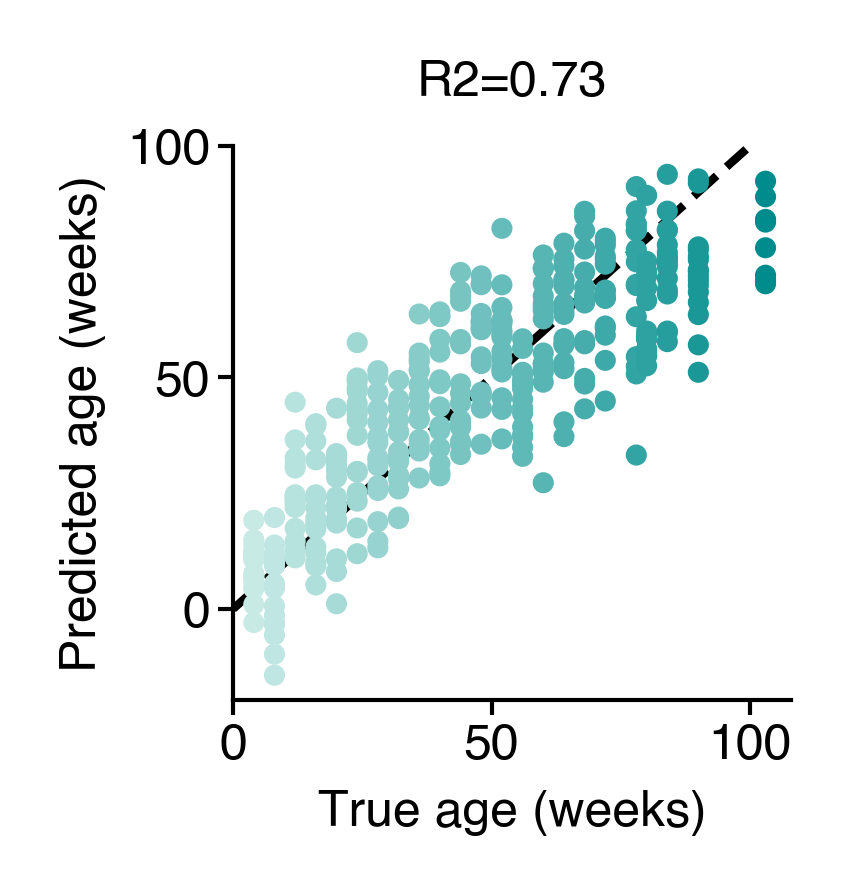

In [59]:
fig = figure(1.2, 1.2)
ax = fig.gca()
plt.scatter(y, preds, c=y, cmap=onto_cmap, s=3)
add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None), yticks=[0, 50, 100], xlabel="True age (weeks)", ylabel="Predicted age (weeks)", title=f"R2={r2s:0.2f}")
sns.despine()
saver(fig, "chron-age-regression-results-logo")

In [60]:
preds = cross_val_predict(
    PLSRegression(n_components=5),
    df,
    y.to_numpy()[:, None],
    groups=y,
    cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
    n_jobs=-1,
).squeeze()
r2s = r2_score(y, preds)
r2s

0.7632764764596744

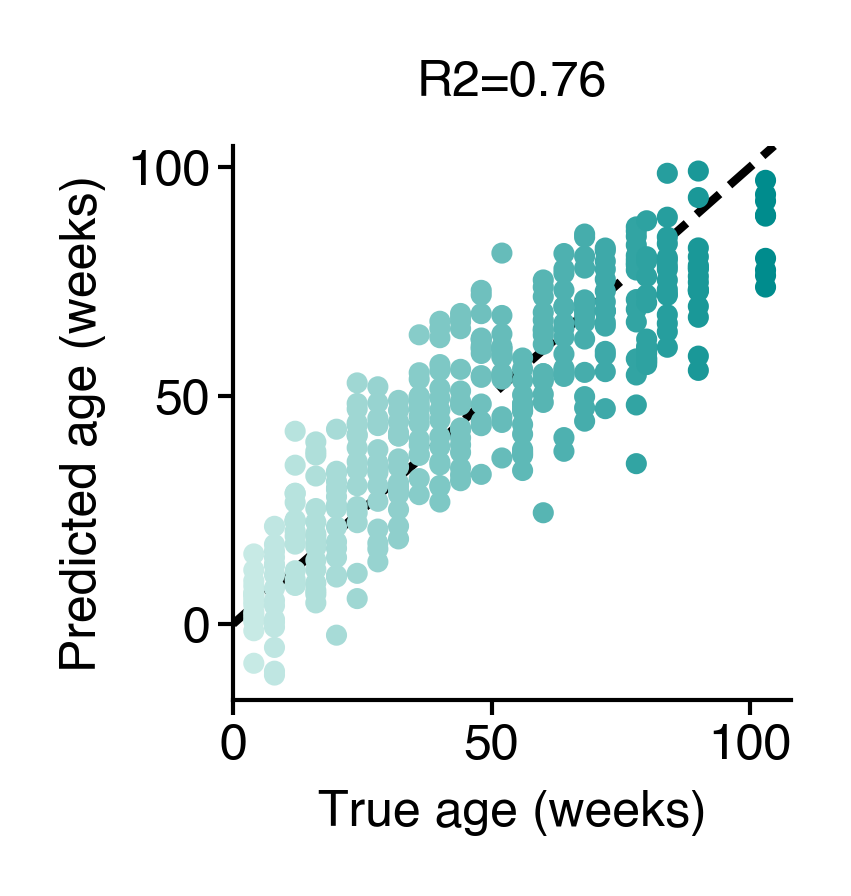

In [61]:
fig = figure(1.2, 1.2)
ax = fig.gca()
plt.scatter(y, preds, c=y, cmap=onto_cmap, s=3)
add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None), yticks=[0, 50, 100], xlabel="True age (weeks)", ylabel="Predicted age (weeks)", title=f"R2={r2s:0.2f}")
sns.despine()
saver(fig, "chron-age-regression-results-stratified")

In [62]:
plt.close('all')

## Entropy of transition matrix

- requires more work to do. Have to load in unprocessed dataframe

In [64]:
from toolz import sliding_window

In [63]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_syllable_df_v00.parquet')
df = df.query('onsets')

In [74]:
def compute_tm(df, max_syllable=100):
    tm = np.zeros((max_syllable, ) * 2)
    for _in, _out in sliding_window(2, df['syllables']):
        tm[_in, _out] += 1
    return tm

In [85]:
trans_out = []
for (age, uuid), _df in df.groupby(['age', 'uuid']):
    tm = compute_tm(_df)
    e_out = entropy(tm + 1, axis=1).mean()
    e_total = entropy((tm + 1).flatten())
    trans_out.append(dict(outgoing_ent=e_out, total_ent=e_total, age=age, uuid=uuid))
trans_out = pd.DataFrame(trans_out)

In [86]:
trans_out

outgoing_ent  total_ent  age                                  uuid
0        4.433360   8.872749    4  055b68ad-b41d-4725-9d54-c8992d92934c
1        4.435564   8.897508    4  06852811-14ea-4fe3-8f6e-81bbd1ead951
2        4.433551   8.877231    4  2bb5e7fa-02cd-4694-accf-fed9651b1beb
3        4.431066   8.815594    4  30315149-532f-4d6a-b3c9-b1dcd1e707fe
4        4.444134   8.906713    4  32221902-9ee7-4d36-a7f4-e76375e3084e
..            ...        ...  ...                                   ...
358      4.504098   9.034860  103  b9e9f69e-9b6d-4220-b2a7-f39f9f918278
359      4.487820   8.989058  103  d344c424-2188-4a5b-b45e-50818128127f
360      4.470005   9.004140  103  dff86510-b65f-4713-aa22-0a4e95f53c23
361      4.487458   8.914250  103  e53d5526-2371-42c1-ab8b-4550d658df60
362      4.466765   8.895386  103  f16bd29c-0284-4226-ab85-ff008abb01e4

[363 rows x 4 columns]

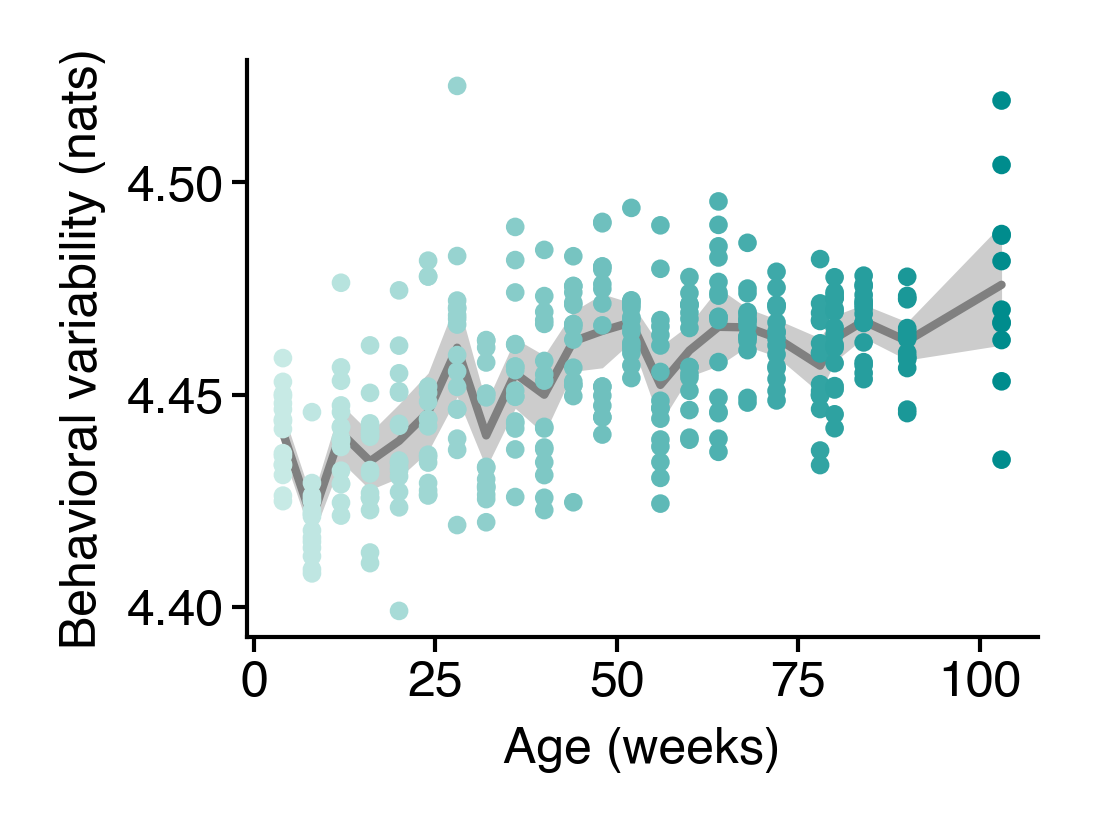

In [89]:
fig = figure(1.7, 1.25)
ax = sns.lineplot(
    data=trans_out,
    x="age",
    y="outgoing_ent",
    zorder=-1,
    color="gray",
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se", 2),
)
ax = sns.scatterplot(
    data=trans_out,
    x="age",
    y="outgoing_ent",
    hue="age",
    palette=onto_cmap,
    linewidths=0,
    s=5,
    legend=False,
)
ax.set(xlabel="Age (weeks)", ylabel="Behavioral variability (nats)")
sns.despine()
fig
saver(fig, "outgoing-transition-entropy-scatter")

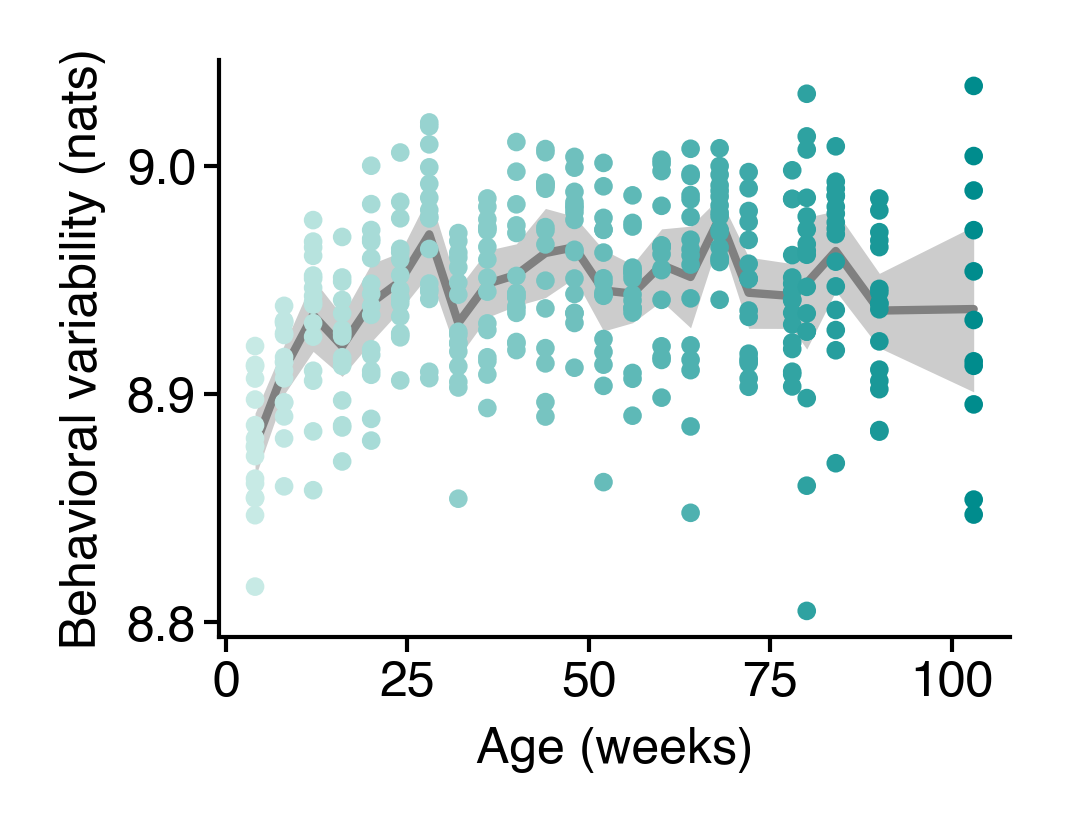

In [90]:
fig = figure(1.7, 1.25)
ax = sns.lineplot(
    data=trans_out,
    x="age",
    y="total_ent",
    zorder=-1,
    color="gray",
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se", 2),
)
ax = sns.scatterplot(
    data=trans_out,
    x="age",
    y="total_ent",
    hue="age",
    palette=onto_cmap,
    linewidths=0,
    s=5,
    legend=False,
)
ax.set(xlabel="Age (weeks)", ylabel="Behavioral variability (nats)")
sns.despine()
fig
saver(fig, "total-transition-entropy-scatter")